<a href="https://colab.research.google.com/github/SkyDriver1979/torque-calculation/blob/main/Torque_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into 'torque-calculation'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 412.53 KiB | 1.59 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Repository: 'deb https://ppa.launchpadcontent.net/alex-p/tesseract-ocr5/ubuntu/ jammy main'
Description:
 The Tesseract OCR engine was one of the top 3 engines in the 1995
 UNLV Accuracy test. Between 1995 and 2006 it had little work done on
 it, but since then it has been improved extensively by Google and is
 probably one of the most accurate open source OCR engines
 available. It can read a wide variety of image formats and convert
 them to text in over 40 languages. This package includes the command
 line tool.
More info: https://launchpad.net/~alex-p/+archive/ubuntu/tesseract-ocr5
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/alex-p-ubun

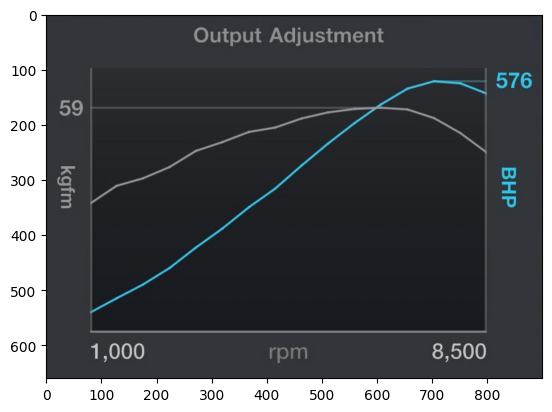

In [1]:
# @title Setup
!rm -rf /content/torque-calculation
!git clone https://github.com/SkyDriver1979/torque-calculation.git
!sudo add-apt-repository -y ppa:alex-p/tesseract-ocr5
!sudo apt update
!sudo apt install tesseract-ocr
!pip -q install pytesseract

import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pytesseract
from operator import itemgetter
%matplotlib inline

diagram = cv2.imread("torque-calculation/diagram.jpg")
plt.imshow(diagram[:,:,::-1])

In [3]:
# @title Processing Functions

def extract_text(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 10, 7, 21)
    return pytesseract.image_to_string(denoised_image)

def extract_diagram_image(image, diagram):
    match_result = cv2.matchTemplate(image, diagram, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match_result)
    h = max_loc[1]
    w = max_loc[0]
    matched_diagram = image[h:h+diagram.shape[0],w:w+diagram.shape[1],:]
    return matched_diagram

def extract_numbers(image):
    def extract_digits(text):
        return ''.join(c for c in text if c.isdigit())

    text = extract_text(image).split("\n")
    text = [line for line in text if len(extract_digits(line))>0]
    bph_max = int(extract_digits(text[0]))
    kgfm_max = int(extract_digits(text[1]))
    rpm_text = [line for line in text if "rpm" in line][0]
    rpm_split = rpm_text.split("rpm")
    rpm_min = int(extract_digits(rpm_split[0]))
    rpm_max = int(extract_digits(rpm_split[1]))
    return rpm_min, rpm_max, kgfm_max, bph_max

def extract_car_name(image):
    ratio = image.shape[0]/2160
    h_min = int(420 * ratio)
    h_max = int(500 * ratio)
    w_max = int(900 * ratio)
    return extract_text(image[h_min:h_max,:w_max,:]).strip()


def find_coordinates(gray_diagram, colour_diagram):
    def is_cyan(pixel):
        return pixel[0] / pixel[2] >= 1.3 and pixel[1] / pixel[2] >= 1.3

    def is_bhp_region(region, x, ymin, colour_diagram):
        for y in range(region[0],region[1]+1):
            if is_cyan(colour_diagram[y+ymin,x]):
                return True
        return False

    def find_regions(slice):
        result = []
        in_region = False
        region_start = 0
        for i in range(len(slice)):
            if in_region:
                if not slice[i]:
                    in_region = False
                    result.append((region_start,i-1))
            else:
                if slice[i]:
                    region_start = i
                    in_region = True
        if in_region:
            result.append((region_start,len(slice)-1))
        return result
    kgfm_x = []
    kgfm_y = []

    bhp_x = []
    bhp_y = []

    working_diagram = gray_diagram > 100
    xaxis = np.count_nonzero(gray_diagram > 60,axis=0) > gray_diagram.shape[0] * 0.5
    #find where X axis begin in image
    for i in range(len(xaxis)//2):
        if xaxis[i]:
            xmin = i
            break

    #find where X axis ends in the image
    for i in range(len(xaxis)//2,len(xaxis)):
        if xaxis[i]:
            xmax = i

    #find where is Y start
    yaxis = np.count_nonzero(working_diagram,axis=1) > gray_diagram.shape[1] * 0.5
    for i in range(len(yaxis)):
        if yaxis[i]:
            ymax = i
            break

    #find where diagram start on Y axis
    yaxis = np.count_nonzero(gray_diagram < 45,axis=1) > gray_diagram.shape[1] * 0.5
    for i in range(len(yaxis)):
        if yaxis[i]:
            ymin = i
            break
    #print(xmin,xmax,ymin,ymax)

    for x in range(xmin, xmax+1):
        found_kgfm = None
        found_bhp = None
        regions = find_regions(working_diagram[ymin:ymax,x])
        if len(regions) >= 3:
            regions = regions[-2:]
        if len(regions) == 2:
            for region in regions:
                if is_bhp_region(region, x, ymin, colour_diagram):
                    found_bhp = region
                else:
                    found_kgfm = region
        else:
            found_kgfm = region

        if found_bhp is not None:
            bhp_x.append(x)
            bhp_y.append(ymax - found_bhp[0])
        if found_kgfm is not None:
            kgfm_x.append(x)
            kgfm_y.append(ymax - found_kgfm[0])

    return pd.Series(data=kgfm_y, index= kgfm_x) , pd.Series(data=bhp_y, index= bhp_x)

def normalize_values(values, rpm_min, rpm_max, y_out_max):
    rpm_in_min = values.index[0]
    rpm_in_max = values.index[-1]
    new_index = np.interp(values.index,[rpm_in_min,rpm_in_max], [rpm_min, rpm_max])
    new_values = np.interp(values.values, [0, values.max()], [0, y_out_max])
    return pd.Series(data=new_values, index= new_index)

def calculate_wheel_speed(torque, gears, gear_names, final_ratio, tyre_diameter_in_meters):
    rpms = torque.index
    #gear_names = [x+'_ws' for x in gear_names]
    base_gear_ratio = rpms * ((math.pi * tyre_diameter_in_meters * 0.06) / final_ratio) # Calculate base gear ratio for each RPM
    gear_list = []
    for i in range(len(gears)):
        if gears[i] != 0:
            # Calculate wheel speed for each gear and all RPMs
            gear_speed = base_gear_ratio / gears[i]
            gear_list.append(gear_speed)
        else:
            # Handle cases where gear ratio is 0
            gear_list.append(np.zeros_like(base_gear_ratio))

    # Transpose the gear_list to have gears as columns and RPMs as index
    return pd.DataFrame(np.array(gear_list).T, columns=gear_names, index=rpms)

def calculate_tractive_force(torque, gears, gear_names, final_ratio, tyre_diameter_in_meters):

    base_torque = torque * (2 * final_ratio / tyre_diameter_in_meters)
    rpms = torque.index
    #gear_names = [x+'_tf' for x in gear_names]
    torque_list = []
    for i in range(len(gears)):
        gear_torque = base_torque * gears[i]
        torque_list.append(gear_torque)
    # Transpose the torque_list to have gears as columns and RPMs as index
    return pd.DataFrame(np.array(torque_list).T, columns=gear_names, index=rpms)

def index_by_speed(df_wheel_speed, df_traction_force):
  # Create a new index from 0 to max value with a step of 0.1
  new_index = np.arange(0, df_wheel_speed.max().max() + 0.1, 0.1)

  # Create a new DataFrame with the new index
  speed_rpm = pd.DataFrame(index=new_index)

  # Interpolate the values from wheel_speed for each gear
  for gear in df_wheel_speed.columns:
    speed_rpm[gear] = np.interp(new_index, df_wheel_speed[gear], df_wheel_speed.index, right=0)

  speed_tractions = pd.DataFrame(index=new_index)
  for gear in df_traction_force.columns:
    speed_tractions[gear] = np.interp(speed_rpm[gear], df_traction_force.index, df_traction_force[gear], right=0)


  return speed_rpm , speed_tractions




4C Gr.3


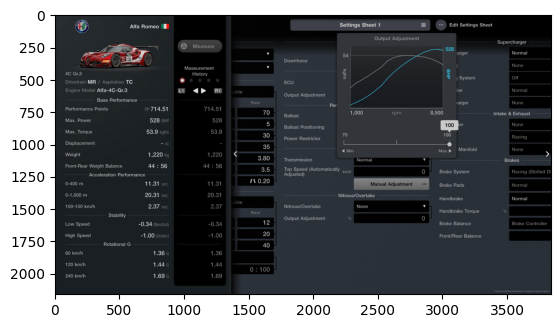

In [4]:
# @title Input parameters
screenshot = 'torque-calculation/sample-screenshot.jpg' # @param {type:"string"}

gear_1 = 2.668 # @param {type:"number"}
gear_2 = 2.172 # @param {type:"number"}
gear_3 = 1.686 # @param {type:"number"}
gear_4 = 1.357 # @param {type:"number"}
gear_5 = 1.097 # @param {type:"number"}
gear_6 = 0.916 # @param {type:"number"}
gear_7 = 0 # @param {type:"number"}
gears = [gear_1, gear_2, gear_3, gear_4, gear_5, gear_6, gear_7]
gear_names = ['1st_Gear','2nd_Gear','3rd_Gear','4th_Gear','5th_Gear','6th_Gear','7th_Gear']

final_ratio = 3.918 # @param {type:"number"}
tyre_diameter_in_meters = 0.698 # @param {type:"number"}

img = cv2.imread(screenshot,cv2.IMREAD_COLOR)
assert img is not None, "Screenshot filename is not correct"
print(extract_car_name(img))
plt.imshow(img[:,:,::-1])





rpm_min = 1000
rpm_max = 8500
kgfm_max = 54
bhp_max = 528


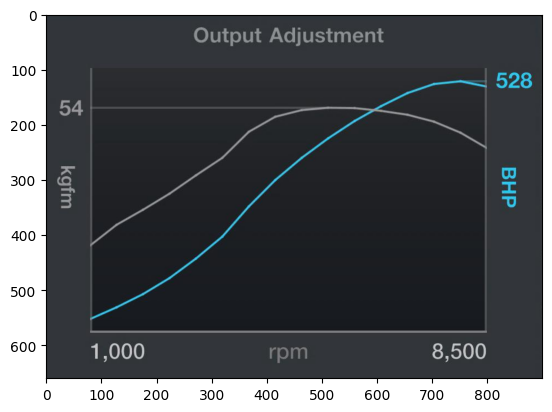

In [5]:
# @title Finding a diagram and extracting values from diagram
matched_diagram = extract_diagram_image(img, diagram)
gray_matched_diagram = cv2.cvtColor(matched_diagram, cv2.COLOR_BGR2GRAY)
kgfm, bhp = find_coordinates(gray_matched_diagram,matched_diagram)
rpm_min, rpm_max, kgfm_max, bhp_max = extract_numbers(matched_diagram)
print(f"rpm_min = {rpm_min}")
print(f"rpm_max = {rpm_max}")
print(f"kgfm_max = {kgfm_max}")
print(f"bhp_max = {bhp_max}")
normalized_kgfm = pd.concat([pd.Series({0: 0}), normalize_values(kgfm, rpm_min, rpm_max, kgfm_max)])
normalized_bhp = normalize_values(bhp, rpm_min, rpm_max, bhp_max)
plt.imshow(matched_diagram[:,:,::-1])

In [5]:
#print(extract_numbers(diagram))
print(extract_car_name(img))

max_value = normalized_kgfm.max()
max_index = normalized_kgfm.idxmax()
print("Max value:", max_value)
print("Index of max value:", max_index)

4C Gr.3
Max value: 54.0
Index of max value: 5422.809457579972


In [6]:
tractive_force = calculate_tractive_force(normalized_kgfm, gears, gear_names, final_ratio, tyre_diameter_in_meters)
tractive_force

,1st_Gear,2nd_Gear,3rd_Gear,4th_Gear,5th_Gear,6th_Gear,7th_Gear
0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1000.000000,833.974085,678.932426,527.016607,424.176474,342.904637,286.326935,0.0
1010.431154,833.974085,678.932426,527.016607,424.176474,342.904637,286.326935,0.0
1020.862309,837.133078,681.504140,529.012882,425.783203,344.203518,287.411507,0.0
1031.293463,837.133078,681.504140,529.012882,425.783203,344.203518,287.411507,0.0
...,...,...,...,...,...,...,...
8458.275382,1396.274794,1136.697471,882.353562,710.174249,574.105491,479.380701,0.0
8468.706537,1393.115801,1134.125757,880.357287,708.567520,572.806610,478.296130,0.0
8479.137691,1393.115801,1134.125757,880.357287,708.567520,572.806610,478.296130,0.0
8489.568846,1389.956809,1131.554044,878.361012,706.960791,571.507728,477.211558,0.0


In [7]:
wheel_speed = calculate_wheel_speed(normalized_kgfm, gears, gear_names, final_ratio, tyre_diameter_in_meters)
wheel_speed

,1st_Gear,2nd_Gear,3rd_Gear,4th_Gear,5th_Gear,6th_Gear,7th_Gear
0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1000.000000,12.586538,15.460812,19.917487,24.746414,30.611562,36.660353,0.0
1010.431154,12.717830,15.622086,20.125249,25.004547,30.930876,37.042763,0.0
1020.862309,12.849122,15.783360,20.333012,25.262681,31.250190,37.425172,0.0
1031.293463,12.980414,15.944634,20.540774,25.520815,31.569503,37.807582,0.0
...,...,...,...,...,...,...,...
8458.275382,106.460404,130.771804,168.467591,209.311981,258.921019,310.083360,0.0
8468.706537,106.591696,130.933078,168.675353,209.570114,259.240333,310.465770,0.0
8479.137691,106.722988,131.094352,168.883115,209.828248,259.559647,310.848179,0.0
8489.568846,106.854280,131.255626,169.090878,210.086382,259.878961,311.230589,0.0


In [8]:

def index_by_speed(df_wheel_speed, df_traction_force):
  # Create a new index from 0 to max value with a step of 0.1
  new_index = np.arange(0, df_wheel_speed.max().max() + 0.1, 0.1)

  # Create a new DataFrame with the new index
  speed_rpm = pd.DataFrame(index=new_index)

  # Interpolate the values from wheel_speed for each gear
  for gear in df_wheel_speed.columns:
    speed_rpm[gear] = np.interp(new_index, df_wheel_speed[gear], df_wheel_speed.index, right=0)

  speed_tractions = pd.DataFrame(index=new_index)
  for gear in df_traction_force.columns:
    speed_tractions[gear] = np.interp(speed_rpm[gear], df_traction_force[gear], df_traction_force.index, right=0)


  return speed_rpm , speed_tractions



In [8]:
speed_rpm, speed_tractions = index_by_speed(wheel_speed, tractive_force)

In [9]:
speed_tractions


,1st_Gear,2nd_Gear,3rd_Gear,4th_Gear,5th_Gear,6th_Gear,7th_Gear
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0.1,6.625921,4.391312,2.645999,1.714093,1.120180,0.781026,0.0
0.2,13.251842,8.782623,5.291999,3.428185,2.240360,1.562052,0.0
0.3,19.877764,13.173935,7.937998,5.142278,3.360540,2.343078,0.0
0.4,26.503685,17.565247,10.583998,6.856371,4.480721,3.124105,0.0
...,...,...,...,...,...,...,...
311.3,0.000000,0.000000,0.000000,0.000000,0.000000,477.211558,0.0
311.4,0.000000,0.000000,0.000000,0.000000,0.000000,477.211558,0.0
311.5,0.000000,0.000000,0.000000,0.000000,0.000000,477.211558,0.0
311.6,0.000000,0.000000,0.000000,0.000000,0.000000,477.211558,0.0


In [10]:
tractive_force.to_csv('tractive_force.csv')
wheel_speed.to_csv('wheel_speed.csv')
